In [1]:
import numpy as np
import matplotlib.pyplot as plt
import xtrack as xt
import xpart as xp
import xcoll as xc
import xobjects as xo

# Preparing statistics for ht condor simulation distorted line

In [2]:
def get_straight_line(t, t1, r1, t2, r2):
    alpha = (r2 - r1) / (t2 - t1)
    return r1 + alpha * (t - t1)

In [3]:
def insert_monitor_bpms(line, num_turns, num_particles):
    tt = line.get_table()
    bph_list = tt.rows['bph.*..0'].name
    env = line.env
    insertions = []
    monitors_elems = []
    monitorBPM_names = []
    for name in bph_list:
        monitorBPM_names.append(name.split('.')[0] + '.' + name.split('.')[1])

        monitors_elems.append(xt.ParticlesMonitor(_context=line._context, 
                                                            num_particles=num_particles, 
                                                            start_at_turn=0, 
                                                            stop_at_turn=num_turns+1))
        env.elements[f'{name}_monitor'] = monitors_elems[-1]
        insertions.append(env.place(f'{name}_monitor', at=line.get_s_position(name)))
    line.insert(insertions, s_tol=1e-6)
    return np.array(monitorBPM_names), monitors_elems

def install_tidp(line, block_mvt=29e-3):
    tidp_ap_tot = 147e-3
    line.discard_tracker()
    tidp = xc.EverestCollimator(length=4.3, material=xc.materials.Carbon, jaw_L= tidp_ap_tot/2 + block_mvt, jaw_R = -tidp_ap_tot/2 + block_mvt)
    line.collimators.install(names=['tidp.11434'], elements=[tidp])
    return tidp

In [4]:
line = xt.Line.from_json('../injection_lines/sps_orbit_md_20250616_v2.json')

line.vars['qph_setvalue'] = 0.5
line.vars['qpv_setvalue'] = 0.5
line.vars['qh_setvalue'] = line.vars['qx0']._value + 0.05
line.vars['qv_setvalue'] = line.vars['qy0']._value + 0.05


tt = line.get_table()
tw = line.twiss()

Loading line from dict:   0%|          | 0/36506 [00:00<?, ?it/s]

Done loading line from dict.           
Compiling ContextCpu kernels...


ld: warning: duplicate -rpath '/Users/lisepauwels/miniforge3/envs/xcoll/lib' ignored
ld: warning: duplicate -rpath '/Users/lisepauwels/miniforge3/envs/xcoll/lib' ignored


Done compiling ContextCpu kernels.
Compiling ContextCpu kernels...


ld: warning: duplicate -rpath '/Users/lisepauwels/miniforge3/envs/xcoll/lib' ignored
ld: warning: duplicate -rpath '/Users/lisepauwels/miniforge3/envs/xcoll/lib' ignored


Done compiling ContextCpu kernels.


In [5]:
#Context and parameters
context = xo.ContextCpu()
cavity_elements, cavity_names = line.get_elements_of_type(xt.Cavity)

num_particles  = 1000
plane = 'DPneg'
delta_emp = 0.307*get_straight_line(1.967, 1.027,0, 1.967, -22e-3)
#delta_emp = 0.307*get_straight_line(0.5, 2.984,0, 0.5, -32e-3)
sweep = delta_emp * cavity_elements[0].frequency * tw.slip_factor
sweep = -abs(sweep) if plane == 'DPpos' else abs(sweep)
num_turns = 7000


for name in cavity_names:
    line[name].frequency = 200e6
    line[name].lag = 180
line['acl.31735'].voltage = 0 #setting 800 cav to 0V
line['actcse.31632'].voltage = 3.5e6

In [6]:
tidp = install_tidp(line)
tw = line.twiss()
part = xp.generate_matched_gaussian_bunch(nemitt_x=2e-6,
                                          nemitt_y=2e-6,
                                          sigma_z=0.224, num_particles=num_particles, line=line)

Compiling ContextCpu kernels...


ld: warning: duplicate -rpath '/Users/lisepauwels/miniforge3/envs/xcoll/lib' ignored
ld: warning: duplicate -rpath '/Users/lisepauwels/miniforge3/envs/xcoll/lib' ignored


Done compiling ContextCpu kernels.


Slicing line:   0%|          | 0/33114 [00:00<?, ?it/s]

Compiling ContextCpu kernels...


ld: warning: duplicate -rpath '/Users/lisepauwels/miniforge3/envs/xcoll/lib' ignored
ld: warning: duplicate -rpath '/Users/lisepauwels/miniforge3/envs/xcoll/lib' ignored


Done compiling ContextCpu kernels.
Compiling ContextCpu kernels...


ld: warning: duplicate -rpath '/Users/lisepauwels/miniforge3/envs/xcoll/lib' ignored
ld: warning: duplicate -rpath '/Users/lisepauwels/miniforge3/envs/xcoll/lib' ignored


Done compiling ContextCpu kernels.
Compiling ContextCpu kernels...


ld: warning: duplicate -rpath '/Users/lisepauwels/miniforge3/envs/xcoll/lib' ignored
ld: warning: duplicate -rpath '/Users/lisepauwels/miniforge3/envs/xcoll/lib' ignored


Done compiling ContextCpu kernels.
*** Maximum RMS bunch length 0.23610110213554208m.
... distance to target bunch length: -2.2226e-01
... distance to target bunch length: 5.5784e-03
... distance to target bunch length: 5.2361e-03
... distance to target bunch length: -6.3267e-03
... distance to target bunch length: 1.9948e-03
... distance to target bunch length: -3.8258e-04
... distance to target bunch length: 5.3833e-05
... distance to target bunch length: 1.2594e-06
... distance to target bunch length: -1.0995e-10
... distance to target bunch length: 1.2805e-07
--> Bunch length: 0.2239999998900487
--> Emittance: 0.30346637784307096


In [7]:
rf_sweep = xc.RFSweep(line)
rf_sweep.info(sweep=sweep, num_turns=num_turns)

line.discard_tracker()
line.build_tracker(_context=xo.ContextCpu(omp_num_threads='auto'))
line.scattering.enable()
rf_sweep.track(sweep=sweep, particles=part, num_turns=num_turns, time=True, with_progress=True)
line.scattering.disable()

KeyboardInterrupt: 

In [ ]:
np.unique(part.at_element, return_counts=True)

(array([   0, 3785]), array([139, 861]))

In [ ]:
line[3785]

View of LimitEllipse(a=0.038, b=0.038)

In [ ]:
line.element_names[3785]

'bpcn.12508.a_aper'

I tried the more aggressive and less aggressive radial steering, both loose on the same location ('bpcn.12508.a_aper'). The other line seem to have another loss location that is completely hidden by this one with the orbit distorsion

In [ ]:
line.get_s_position('bpcn.12508.a_aper')

np.float64(799.5901999999999)

# Putting two loss locations out to see where we start loosing elsewhere

In [8]:
line = xt.Line.from_json('../injection_lines/sps_with_aperture_inj_q20_beam_sagitta5.json')

line.vars['qph_setvalue'] = 0.5
line.vars['qpv_setvalue'] = 0.5
line.vars['qh_setvalue'] = line.vars['qx0']._value + 0.05
line.vars['qv_setvalue'] = line.vars['qy0']._value + 0.05


cavity_elements, cavity_names = line.get_elements_of_type(xt.Cavity)

for name in cavity_names:
    line[name].frequency = 200e6
    line[name].lag = 180
line['acl.31735'].voltage = 0 #setting 800 cav to 0V
line['actcse.31632'].voltage = 3.0e6

tt = line.get_table()
tw = line.twiss()

Loading line from dict:   0%|          | 0/36404 [00:00<?, ?it/s]

Done loading line from dict.           
Compiling ContextCpu kernels...


ld: warning: duplicate -rpath '/Users/lisepauwels/miniforge3/envs/xcoll/lib' ignored
ld: warning: duplicate -rpath '/Users/lisepauwels/miniforge3/envs/xcoll/lib' ignored


Done compiling ContextCpu kernels.
Compiling ContextCpu kernels...


ld: warning: duplicate -rpath '/Users/lisepauwels/miniforge3/envs/xcoll/lib' ignored
ld: warning: duplicate -rpath '/Users/lisepauwels/miniforge3/envs/xcoll/lib' ignored


Done compiling ContextCpu kernels.


In [9]:
context = xo.ContextCpu()

aperture_mvt = 3e-3

num_particles  = 1000
plane = 'DPneg'
sweep = 6000
sweep = -abs(sweep) if plane == 'DPpos' else abs(sweep)
num_turns = 6000

In [10]:
# Changing apertures of loss locations
line['bpcn.12508.a_aper'].a += aperture_mvt
line['bpcn.12508.b_aper'].a += aperture_mvt
line['bpcn.61108.a_aper'].a += aperture_mvt
line['bpcn.61108.b_aper'].a += aperture_mvt

In [11]:
tidp = install_tidp(line)
tt = line.get_table()
tw = line.twiss()
part = xp.generate_matched_gaussian_bunch(nemitt_x=2e-6,
                                          nemitt_y=2e-6,
                                          sigma_z=0.224, num_particles=num_particles, line=line)

Slicing line:   0%|          | 0/33012 [00:00<?, ?it/s]

Compiling ContextCpu kernels...


ld: warning: duplicate -rpath '/Users/lisepauwels/miniforge3/envs/xcoll/lib' ignored
ld: warning: duplicate -rpath '/Users/lisepauwels/miniforge3/envs/xcoll/lib' ignored


Done compiling ContextCpu kernels.
Compiling ContextCpu kernels...


ld: warning: duplicate -rpath '/Users/lisepauwels/miniforge3/envs/xcoll/lib' ignored
ld: warning: duplicate -rpath '/Users/lisepauwels/miniforge3/envs/xcoll/lib' ignored


Done compiling ContextCpu kernels.
*** Maximum RMS bunch length 0.23610110213554214m.
... distance to target bunch length: -2.2226e-01
... distance to target bunch length: 5.5784e-03
... distance to target bunch length: 5.2361e-03
... distance to target bunch length: -6.3267e-03
... distance to target bunch length: 1.9948e-03
... distance to target bunch length: -3.8258e-04
... distance to target bunch length: 5.3833e-05
... distance to target bunch length: 1.2594e-06
... distance to target bunch length: -1.0995e-10
... distance to target bunch length: 1.2805e-07
--> Bunch length: 0.22399999989004873
--> Emittance: 0.28106907515669655


In [12]:
rf_sweep = xc.RFSweep(line)
rf_sweep.info(sweep=sweep, num_turns=num_turns)

line.discard_tracker()
line.build_tracker(_context=xo.ContextCpu(omp_num_threads='auto'))
line.scattering.enable()
rf_sweep.track(sweep=sweep, particles=part, num_turns=num_turns, time=True, with_progress=True)
line.scattering.disable()

Compiling ContextCpu kernels...


ld: warning: duplicate -rpath '/Users/lisepauwels/miniforge3/envs/xcoll/lib' ignored
ld: warning: duplicate -rpath '/Users/lisepauwels/miniforge3/envs/xcoll/lib' ignored


Done compiling ContextCpu kernels.
Compiling ContextCpu kernels...


ld: warning: duplicate -rpath '/Users/lisepauwels/miniforge3/envs/xcoll/lib' ignored
ld: warning: duplicate -rpath '/Users/lisepauwels/miniforge3/envs/xcoll/lib' ignored


Done compiling ContextCpu kernels.
The current frequency is 200000000.0Hz, adding 1.0Hz per turn until 200006000.0 (for 6000 turns).
This sweep will move the center of the bucket with Δδ = -0.016896947679657257 (-2.81975385240468 buckets).
Compiling ContextCpu kernels...


ld: warning: duplicate -rpath '/Users/lisepauwels/miniforge3/envs/xcoll/lib' ignored
ld: warning: duplicate -rpath '/Users/lisepauwels/miniforge3/envs/xcoll/lib' ignored


Done compiling ContextCpu kernels.


Tracking:   0%|          | 0/6000 [00:00<?, ?it/s]

In [ ]:
part.to_json('test.json')

# 1mm open

In [ ]:
idxs, counts = np.unique(part.at_element, return_counts=True)

In [ ]:
for idx in idxs:
    print(f'{line.element_names[idx]}: {counts[np.where(idxs == idx)[0][0]]} particles lost')

sps$start: 2 particles lost
vcak.12501.a_aper: 2 particles lost
bpcn.12508.a_aper: 961 particles lost
vcak.22501.a_aper: 5 particles lost
vcak.32501.a_aper: 2 particles lost
vcak.52501.a_aper: 19 particles lost
bpcn.61108.a_aper: 7 particles lost
vcak.62501.a_aper: 2 particles lost


# 2mm open

In [ ]:
idxs, counts = np.unique(part.at_element, return_counts=True)

In [ ]:
for idx in idxs:
    print(f'{line.element_names[idx]}: {counts[np.where(idxs == idx)[0][0]]} particles lost')

sps$start: 1 particles lost
vcak.12501.a_aper: 107 particles lost
bpcn.12508.a_aper: 383 particles lost
vcak.22501.a_aper: 70 particles lost
vcak.32501.a_aper: 177 particles lost
vcak.42501.a_aper: 31 particles lost
vcak.52501.a_aper: 180 particles lost
vcak.62501.a_aper: 51 particles lost


# 3mm open

In [13]:
idxs, counts = np.unique(part.at_element, return_counts=True)

In [14]:
for idx in idxs:
    print(f'{line.element_names[idx]}: {counts[np.where(idxs == idx)[0][0]]} particles lost')

sps$start: 1 particles lost
vcak.12501.a_aper: 151 particles lost
vcak.22501.a_aper: 86 particles lost
vcak.32501.a_aper: 269 particles lost
vcak.42501.a_aper: 194 particles lost
vcak.52501.a_aper: 204 particles lost
vcak.62501.a_aper: 95 particles lost


In [19]:
ThisLM = xc.LossMap(line, line_is_reversed=False, part=part)
ThisLM.to_json(file='test.json')

Performing the aperture losses refinement.
Compiling ContextCpu kernels...


ld: warning: duplicate -rpath '/Users/lisepauwels/miniforge3/envs/xcoll/lib' ignored
ld: warning: duplicate -rpath '/Users/lisepauwels/miniforge3/envs/xcoll/lib' ignored


Done compiling ContextCpu kernels.


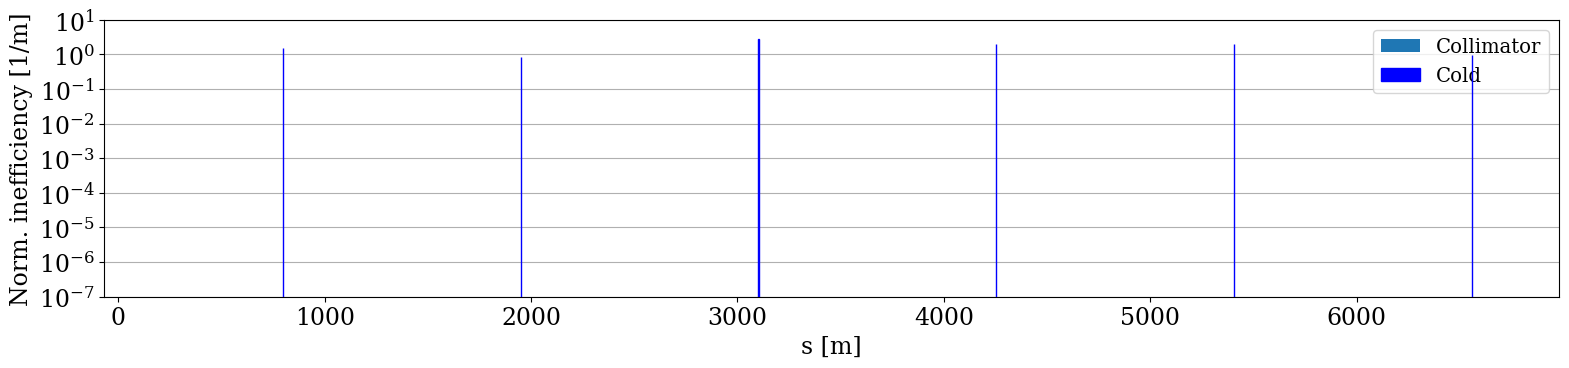

(<Figure size 1600x400 with 1 Axes>,
 <Axes: xlabel='s [m]', ylabel='Norm. inefficiency [1/m]'>)

In [20]:
ThisLM.plot()

In [21]:
LM2 = xc.LossMap.from_json('test.json')

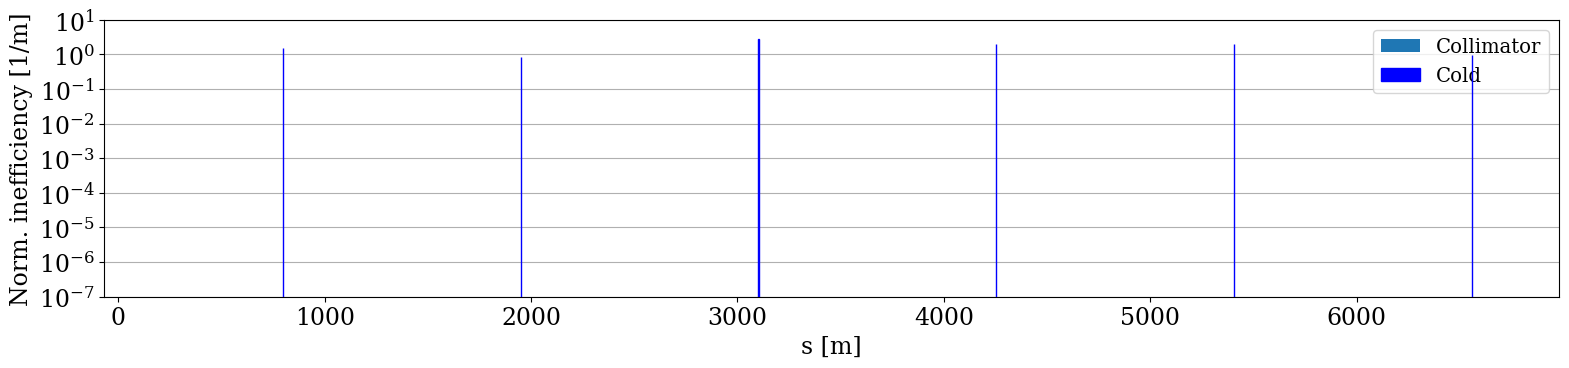

(<Figure size 1600x400 with 1 Axes>,
 <Axes: xlabel='s [m]', ylabel='Norm. inefficiency [1/m]'>)

In [22]:
LM2.plot()

In [ ]:
LM2 = xc.LossMap

In [16]:
import lossmaps as lm

 If you are on SWAN and did not expect this warning, then restart and load the 'NXCals Pro' software stack.


In [17]:
ThisLM = lm.SimulatedLossMap(lmtype=lm.LMType.B1H, machine=lm.Machine.SPS)
ThisLM.load_data_json(json_files=['test.json'])

KeyError: 's'

In [23]:
line = xt.Line.from_json('../injection_lines/sps_orbit_md_20250616_v2.json')

Loading line from dict:   0%|          | 0/36506 [00:00<?, ?it/s]

Done loading line from dict.           


In [24]:
tw = line.twiss()

Compiling ContextCpu kernels...


ld: warning: duplicate -rpath '/Users/lisepauwels/miniforge3/envs/xcoll/lib' ignored
ld: warning: duplicate -rpath '/Users/lisepauwels/miniforge3/envs/xcoll/lib' ignored


Done compiling ContextCpu kernels.
Compiling ContextCpu kernels...


ld: warning: duplicate -rpath '/Users/lisepauwels/miniforge3/envs/xcoll/lib' ignored
ld: warning: duplicate -rpath '/Users/lisepauwels/miniforge3/envs/xcoll/lib' ignored


Done compiling ContextCpu kernels.


In [25]:
tw.gamma0

np.float64(27.643342389704696)

In [28]:
line.get_length()/(2*np.pi)

np.float64(1099.9999939683914)